<a href="https://colab.research.google.com/github/gabriele16/abinitio-train/blob/main/colab/abinitio-train-workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics simulations with NequIP, Allegro and CP2K

<center>
<img src="https://github.com/mir-group/allegro/blob/main/logo.png?raw=true" width="30%">
<img src="https://github.com/mir-group/nequip/blob/main/logo.png?raw=true" width="30%">
<center/>

<img src="https://github.com/gabriele16/cp2k/blob/master/tools/logo/cp2k_logo_500.png?raw=true" width="30%">




### Open in colab and change the runtime to use the GPU if you have not done so already

### Install dependencies, these include pytorch, nequip, allegro and other common packages


In [3]:
%%capture
! rm -rf abinitio-train
! git clone  https://github.com/gabriele16/abinitio-train.git
! pip install requirements.txt
!git clone --depth 1 https://github.com/mir-group/allegro.git
!pip install allegro/

In [3]:
# fix colab imports
import site
site.main()

# set to allow anonymous WandB
import os
os.environ["WANDB_ANONYMOUS"] = "must"


### Check Pytorch and whether it works correctly on the GPU

In [4]:
import torch
print("*****************************")
print("torch version: ", torch.__version__)
print("*****************************")
print("cuda is available: ", torch.cuda.is_available())
print("*****************************")
print("cuda version:")
!nvcc --version
print("*****************************")
print("check which GPU is being used (important only if attempting compilation of CP2K with CUDA):")
print("CP2K is optimized to run on the GPU with the folloging architectures: K20X, K40, K80, P100, V100, Mi50, Mi100, Mi250")
!nvidia-smi
print("*****************************")
print("check path where cuda is installed and adjust EXPORT PATH in the cp2k installation if necessary:")
print("*****************************")
!which nvcc

*****************************
torch version:  1.12.1+cu102
*****************************
cuda is available:  True
*****************************
cuda version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
*****************************
check which GPU is being used (important only if attempting compilation of CP2K with CUDA):
CP2K is optimized to run on the GPU with the folloging architectures: K20X, K40, K80, P100, V100, Mi50, Mi100, Mi250
Tue May  2 17:59:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         M

Clone the CP2K repository

In [5]:
%%capture
!rm -rf cp2k
! git clone --recursive https://github.com/gabriele16/cp2k.git cp2k

## Download a precompiled cp2k binary and run a test. 


In [6]:
%%capture
! gdown https://drive.google.com/uc?id=1hbFxjV657q5C_09gOE8ebxQFIl23b50u
! tar -xzvf cp2k_prebuilt_cuda.tar.gz 

In [7]:
! cp -r cp2k_prebuilt_cuda/exe cp2k/.
! cp -r cp2k_prebuilt_cuda/arch/* cp2k/arch/. 
! mv cp2k/tools/toolchain cp2k/tools/toolchain_not_built
! cp -r cp2k_prebuilt_cuda/toolchain cp2k/tools/.

In [8]:
! wget https://download.pytorch.org/libtorch/cu118/libtorch-cxx11-abi-shared-with-deps-2.0.0%2Bcu118.zip
! unzip /content/libtorch-cxx11-abi-shared-with-deps-2.0.0+cu118.zip

Streaming output truncated to the last 5000 lines.
  inflating: libtorch/include/ATen/ops/fft_ifft2_native.h  
  inflating: libtorch/include/ATen/ops/fft_ifft2_ops.h  
  inflating: libtorch/include/ATen/ops/fft_ifft_compositeimplicitautograd_dispatch.h  
  inflating: libtorch/include/ATen/ops/fft_ifft_native.h  
  inflating: libtorch/include/ATen/ops/fft_ifft_ops.h  
  inflating: libtorch/include/ATen/ops/fft_ifftn.h  
  inflating: libtorch/include/ATen/ops/fft_ifftn_compositeimplicitautograd_dispatch.h  
  inflating: libtorch/include/ATen/ops/fft_ifftn_native.h  
  inflating: libtorch/include/ATen/ops/fft_ifftn_ops.h  
  inflating: libtorch/include/ATen/ops/fft_ifftshift.h  
  inflating: libtorch/include/ATen/ops/fft_ifftshift_compositeimplicitautograd_dispatch.h  
  inflating: libtorch/include/ATen/ops/fft_ifftshift_native.h  
  inflating: libtorch/include/ATen/ops/fft_ifftshift_ops.h  
  inflating: libtorch/include/ATen/ops/fft_ihfft.h  
  inflating: libtorch/include/ATen/ops/fft_ih

In [9]:
! chmod 777 cp2k/exe/local_cuda/cp2k.ssmp &&  source /content/cp2k/tools/toolchain/install/setup 
! cd cp2k/tests/Fist/regtest-allegro/  &&  /content/cp2k/exe/local_cuda/cp2k.ssmp -i Allegro_si_MD.inp 

 DBCSR| CPU Multiplication driver                                           BLAS (U)
 DBCSR| Multrec recursion limit                                              512 (U)
 DBCSR| Multiplication stack size                                          30000 (D)
 DBCSR| Maximum elements for images                                    UNLIMITED (U)
 DBCSR| Multiplicative factor virtual images                                   1 (U)
 DBCSR| Use multiplication densification                                       F (D)
 DBCSR| Multiplication size stacks                                             3 (U)
 DBCSR| Use memory pool for CPU allocation                                     F (U)
 DBCSR| OMP: Current number of threads                                         2
 DBCSR| OMP: Max number of threads                                             2
 DBCSR| ACC: Number of devices/node                                            1
 DBCSR| ACC: Number of stack-buffers per thread                              

### Import PyTorch, numpy etc.
### Set-up the directory containing the training set

In [11]:
import numpy as np
import pandas as pd
import os

os.environ["WANDB_ANONYMOUS"] = "must"
from ase.io import read, write

import warnings
import os
data_dir = "/content/abinitio-train/datasets"

np.random.seed(0)
if torch.cuda.is_available():
  torch.cuda.manual_seed(0)
else:
  torch.manual_seed(0)  

### Workflow:
* Train: using a data set, train the neural network, in this case we train on 1000 configurations and perform validation on 100.
* Evaluate: evaluate the error on total energies and forces using unseen data, about 2000 configurations.
* Deploy: convert the Python-based model into a stand-alone potential file for fast execution
* Run: run Molecular Dynamics in CP2K 

### Train a model

Here, we will train an Allegro potential

In [13]:
! cd abinitio-train/datasets/ && tar -xzvf wat_bil_gra_aimd.tar.gz

wat_bil_gra_aimd/
wat_bil_gra_aimd/wat_pos_frc.extxyz
wat_bil_gra_aimd/celldata.dat


### Below we explicitly write the input to train the model with NequIP/Allegro

In [15]:
allegro_input = """
# general
root: results/water-bil-gra
run_name: water-bil-gra
seed: 42
dataset_seed: 42
append: true
default_dtype: float32

# -- network --
model_builders:
 - allegro.model.Allegro
 # the typical model builders from `nequip` can still be used:
 - PerSpeciesRescale
 - ForceOutput
 - RescaleEnergyEtc

# cutoffs
r_max: 4.925
avg_num_neighbors: auto

# radial basis
BesselBasis_trainable: true
PolynomialCutoff_p: 6   

# symmetry
l_max: 1
parity: o3_full   

# Allegro layers:
num_layers: 1
env_embed_multiplicity: 8
embed_initial_edge: true

two_body_latent_mlp_latent_dimensions: [32, 64, 128]
two_body_latent_mlp_nonlinearity: silu
two_body_latent_mlp_initialization: uniform

latent_mlp_latent_dimensions: [128]
latent_mlp_nonlinearity: silu
latent_mlp_initialization: uniform
latent_resnet: true

env_embed_mlp_latent_dimensions: []
env_embed_mlp_nonlinearity: null
env_embed_mlp_initialization: uniform

# - end allegro layers -

# Final MLP to go from Allegro latent space to edge energies:
edge_eng_mlp_latent_dimensions: [32]
edge_eng_mlp_nonlinearity: null
edge_eng_mlp_initialization: uniform

include_keys:
  - user_label
key_mapping:
  user_label: label0

# -- data --
dataset: ase                                                                   
dataset_file_name: /content/abinitio-train/datasets/wat_bil_gra_aimd/wat_pos_frc.extxyz                     # path to data set file
ase_args:
  format: extxyz

# A mapping of chemical species to type indexes is necessary if the dataset is provided with atomic numbers instead of type indexes.
chemical_symbols:
  - C
  - H
  - O

# logging
wandb: false
#wandb_project: allegro-water-tutorial
verbose: info
log_batch_freq: 10

# training
n_train: 400
n_val: 50
batch_size: 1
max_epochs: 50
learning_rate: 0.002
train_val_split: random
shuffle: true
metrics_key: validation_loss

# use an exponential moving average of the weights
use_ema: true
ema_decay: 0.99
ema_use_num_updates: true

# loss function
loss_coeffs:
  forces: 1.
  total_energy:
    - 1.
    - PerAtomMSELoss

# optimizer
optimizer_name: Adam
optimizer_params:
  amsgrad: false
  betas: !!python/tuple
  - 0.9
  - 0.999
  eps: 1.0e-08
  weight_decay: 0.

metrics_components:
  - - forces                               # key 
    - mae                                  # "rmse" or "mae"
  - - forces
    - rmse
  - - total_energy
    - mae    
  - - total_energy
    - mae
    - PerAtom: True                        # if true, energy is normalized by the number of atoms

# lr scheduler, drop lr if no improvement for 50 epochs
lr_scheduler_name: ReduceLROnPlateau
lr_scheduler_patience: 50
lr_scheduler_factor: 0.5

early_stopping_lower_bounds:
  LR: 1.0e-5

early_stopping_patiences:
  validation_loss: 100
"""

with open("allegro/configs/allegro-water-bil-gra.yaml", "w") as f:
    f.write(allegro_input)

### Train with Allegro for a maximum of 50 epochs for time limits, it should take 20-30 min.

In [ ]:
!rm -rf ./results
!nequip-train allegro/configs/allegro-water-bil-gra.yaml --equivariance-test

Torch device: cuda
Processing dataset...
Loaded data: Batch(atomic_numbers=[677160, 1], batch=[677160], cell=[513, 3, 3], edge_cell_shift=[32011270, 3], edge_index=[2, 32011270], forces=[677160, 3], pbc=[513, 3], pos=[677160, 3], ptr=[514], total_energy=[513, 1])
    processed data size: ~880.65 MB
Cached processed data to disk
Done!
Successfully loaded the data set of type ASEDataset(513)...
Replace string dataset_forces_rms to 1.030919075012207
Replace string dataset_per_atom_total_energy_mean to -155.98239135742188
Atomic outputs are scaled by: [H, C, O: 1.030919], shifted by [H, C, O: -155.982391].
Replace string dataset_forces_rms to 1.030919075012207
Initially outputs are globally scaled by: 1.030919075012207, total_energy are globally shifted by None.
Successfully built the network...
/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:276: UserWarning: operator() profile_node %884 : int[] = prim::profile_ivalue(%882)
 does not have profile information (Triggered 

## Evaluate the test error
##### We get rather small errors in the forces of ~50 meV/A

In [ ]:
!nequip-evaluate --train-dir results/water-tutorial/water --batch-size 1
#! nequip-evaluate --train-dir results/water-bil-gra --batch-size 1

Using device: cuda
Loading model... 
loaded model from training session
Loading original dataset...
Loaded dataset specified in config.yaml.
Using origial training dataset (3117 frames) minus training (1000 frames) and validation frames (100 frames), yielding a test set size of 2017 frames.
Starting...
  0% 0/2017 [00:00<?, ?it/s]

  0% 1/2017 [00:00<20:09,  1.67it/s]
  0% 2/2017 [00:01<31:44,  1.06it/s]
  0% 3/2017 [00:08<2:02:44,  3.66s/it]



  0% 7/2017 [00:08<34:32,  1.03s/it]  





  1% 13/2017 [00:08<13:53,  2.40it/s]




  1% 18/2017 [00:08<08:21,  3.99it/s]




  1% 23/2017 [00:09<05:28,  6.08it/s]




  1% 28/2017 [00:09<03:47,  8.74it/s]





  2% 34/2017 [00:09<02:35, 12.75it/s]





  2% 40/2017 [00:09<01:54, 17.29it/s]





  2% 46/2017 [00:09<01:29, 22.13it/s]




  3% 51/2017 [00:09<01:17, 25.24it/s]




  3% 56/2017 [00:09<01:12, 27.13it/s]




  3% 61/2017 [00:09<01:06, 29.48it/s]




  3% 66/2017 [00:10<01:00, 32.19it/s]







  4% 74/2017 [00:10<00:46, 41.54it/s]


### Deploy the model

We now convert the model to a potential file. This makes it independent of NequIP and we can load it in CP2K to run MD.

In [ ]:
!nequip-deploy build --train-dir results/water-tutorial/water water-deploy.pth
# nequip-deploy build --train-dir results/water-bil-gra/water-bil-gra water-bil-gra-deploy.pth

INFO:root:Loading best_model from training session...
INFO:root:Compiled & optimized model.


# CP2K

We are now in a position to run MD with our potential.

Set up a simple cp2k input file, you can find an example file inside ```cp2k/tests/Fist/regtest-allegro```




CAUTION: Be careful with the units of the .pth model file. One can explicitly specify the units of this file since CP2K input defaults as Angstrom for lengths and A.U. for everything else.

### We now run MD of bulk water at 360 K using 64 molecules in the NVT ensemble for 10 ps (20,000 steps)

---



In [ ]:
cp2k_input_md = """
&GLOBAL
  PROJECT water_bil_gra
  RUN_TYPE MD
&END GLOBAL
&FORCE_EVAL
  METHOD FIST
  &MM
    &FORCEFIELD
     &NONBONDED
     &ALLEGRO
        ATOMS H O C
        PARM_FILE_NAME ./water-deploy.pth
        UNIT_COORDS angstrom
        UNIT_ENERGY eV
        UNIT_FORCES eV*Angstrom^-1
     &END ALLEGRO
    &END NONBONDED
    &END FORCEFIELD
    &POISSON
      &EWALD
        EWALD_TYPE none
      &END EWALD
    &END POISSON
  &END MM
  &SUBSYS
    &CELL
       ABC 12.4138 12.4138 12.4138
#      MULTIPLE_UNIT_CELL 2 2 2
    &END CELL
    &COORD

  H      12.415139       2.233125      11.257611
   H      11.922476       1.573799       9.986994
   H       5.608192       3.371543       8.971482
   H       6.731226       3.060851       8.004962
   H      -0.169205       1.565594       7.589645
   H      -0.455440       2.954771       8.118939
   H      12.125168       2.826463       1.205443
   H      12.888828       2.969761       2.504745
   H      11.553255       4.386613      11.465566
   H      12.818281       4.960808      12.067151
   H       7.049495       1.772344       4.247898
   H       6.353019       0.798145       5.174047
   H       7.781850       7.384852       5.420566
   H       9.103203       6.754017       5.035898
   H      12.771232      11.788645       8.931744
   H      12.018035      10.650652       8.276334
   H       3.557245       3.792529       9.848846
   H       2.543844       4.884102       9.577958
   H       2.320235       4.521250       6.329813
   H       2.872128       3.749963       7.509824
   H       1.209685       7.121391       1.140501
   H       2.238885       6.038801       0.894245
   H       2.763109       8.856353       2.336735
   H       1.329379       9.047369       2.783755
   H       4.315639      11.533388       9.203449
   H       3.098742      12.433043       9.244412
   H       5.987369       3.448974       3.590530
   H       5.813096       3.419344       2.086985
   H       1.057126       1.675344       4.969379
   H       2.248496       2.292119       5.670892
   H       8.508264       1.653337       7.464411
   H       8.066015       2.034597       6.067646
   H       5.197835       2.915542      11.821572
   H       6.630900       3.329981      12.079371
   H      10.788986       6.436672       2.127933
   H      11.657923       5.463602       1.359832
   H       3.544476       1.634958      10.977765
   H       4.755770       1.455054      10.087655
   H       4.465371       3.375459       5.665294
   H       5.682663       4.264430       5.524498
   H       6.174815      11.778676       1.582954
   H       5.713640      12.089924       0.174999
   H       3.476076       1.498708       2.028983
   H       2.730229       2.134295       3.182949
   H       7.119624       5.936450       7.474030
   H       8.536492       5.799405       6.958665
   H       5.909499       5.717477      11.667621
   H       6.125402       6.196758      13.087330
   H      11.203499      12.513536      11.804844
   H      10.260930      12.300153      12.970145
   H       9.985036       3.927685       2.878172
   H       8.545584       3.468329       2.972331
   H       1.399882       6.620092       7.093246
   H       0.963561       6.112523       5.735345
   H       8.067363       3.674002       9.979955
   H       8.000737       2.375959      10.756190
   H      11.821629      10.402510      12.020482
   H      12.206854       8.983242      12.379892
   H       3.461473       7.606485       7.889688
   H       3.844478       6.304711       8.560946
   H       3.179884       7.585614      11.148494
   H       4.401957       7.652030      12.039573
   H      11.573777       5.053211       7.169515
   H      10.342076       4.186083       7.320831
   H      10.065640       8.919194       1.760981
   H       9.629585       8.322499       0.439729
   H       1.396302       6.546079       9.625630
   H       1.405516       6.479759      11.138049
   H       4.024008       1.232518       5.405828
   H       4.736858       0.579881       6.571077
   H       9.452293      12.313381       8.732772
   H       8.976559      11.502788       7.545965
   H       1.834701      10.012311       0.153462
   H       3.295197       9.836403      -0.204175
   H       7.056724      11.401702       4.095264
   H       6.499038      10.020287       3.825865
   H       1.365541       0.487338      11.013887
   H       2.501591      -0.428131      11.417871
   H       8.644279       1.812362       1.005409
   H       8.142674       0.388030       1.112955
   H       1.272659       8.365063       8.191888
   H       2.142485       8.877768       7.063867
   H       8.961493       7.826192       9.265523
   H       9.227102       8.487654      10.601118
   H      10.150144       7.758934       6.392768
   H      10.596082       9.187988       6.167290
   H       3.463106       4.096188       2.129414
   H       3.919461       4.539801       0.755791
   H       7.418998       9.394959      12.028876
   H       7.430413       7.883095      12.106546
   H       7.972905      10.220334       5.841196
   H       7.675111       9.631498       7.203725
   H       5.332446       6.381336       6.419473
   H       5.000025       6.434186       4.943466
   H      11.575078       2.271167       4.412540
   H      11.219802       0.847030       4.783357
   H       8.865342       9.721516       3.843998
   H      10.000732      10.719285       3.758898
   H       3.186196      10.476397       5.265333
   H       4.407331      11.335128       5.013723
   H       0.558187       7.255936       3.859331
   H       0.341672       5.789383       3.552346
   H       7.459933       6.526049       3.229193
   H       6.696228       5.483739       2.440372
   H       3.864872       6.313007       2.849385
   H       2.876419       6.621201       3.953862
   H       5.631529       8.079145       8.753997
   H       7.003296       7.568245       8.367822
   H       9.615413       0.527902       3.031755
   H       8.962985       0.109366       4.332162
   H       3.825854      11.139182       1.474087
   H       4.063988      11.063232       2.967211
   H       5.784391       7.914558       2.708486
   H       4.780461       8.655167       3.566110
   H      10.880659       5.444664       5.046607
   H       9.593331       4.687991       4.797350
   H      11.562317       8.960134       3.376765
   H      11.926084       8.816948       4.839320
   H       2.856874      11.297981       7.433660
   H       1.492332      11.195517       6.786033
   H       7.145820       0.090200       9.749009
   H       7.227275       0.077690      11.260665
   H       4.662021       9.538430      10.798155
   H       5.994537       9.833472      10.142985
   H      10.544299       6.595857      10.301445
   H      11.281750       5.653082       9.374494
   H      12.103020       8.841164      10.006916
   H      11.491592       8.576221       8.647557
   O      12.235322       1.376642      10.869880
   O       6.445390       3.706940       8.650794
   O       0.085977       2.181322       8.276663
   O      12.052554       2.671366       2.147199
   O      12.250036       4.190930      12.092014
   O       7.187422       0.959062       4.733469
   O       8.346457       7.210040       4.667644
   O      12.361546      11.527875       8.106887
   O       3.299984       4.440816       9.193275
   O       2.855829       3.759909       6.552815
   O       1.392494       6.362753       0.586172
   O       1.858645       8.694013       2.068738
   O       3.770231      12.094519       8.652183
   O       6.432508       3.669828       2.772418
   O       1.998724       1.820217       4.876440
   O       8.248581       2.404730       6.931303
   O       5.753814       3.360029      12.461534
   O      11.322212       5.649239       2.236798
   O       4.277318       2.113956      10.590808
   O       5.405015       3.349247       5.484702
   O       6.493278      11.869958       0.684912
   O       3.275250       2.346576       2.425241
   O       7.981003       6.352512       7.507970
   O       5.985990       6.512854      12.194648
   O      10.636714      11.856872      12.209540
   O       9.312283       3.670384       3.508594
   O       1.106885       5.830301       6.638695
   O       8.008007       3.326363      10.869818
   O      12.403000       9.687405      11.761901
   O       4.219782       7.085315       8.153470
   O       3.781557       8.203821      11.563272
   O      11.088898       4.532081       7.809475
   O      10.387548       8.408890       1.017882
   O       1.979016       6.418091      10.374159
   O       4.660547       0.549666       5.617403
   O       8.745880      12.256257       8.089383
   O       2.662041      10.489890       0.092980
   O       7.241661      10.471815       4.226946
   O       2.276827       0.276647      10.810417
   O       8.887733       0.946877       1.333885
   O       1.943554       8.088552       7.567650
   O       9.667942       8.056759       9.868847
   O      10.905491       8.339638       6.484782
   O       3.507733       4.862402       1.557439
   O       8.010457       8.642846      12.055969
   O       8.374446      10.035932       6.690309
   O       5.635247       6.076875       5.563993
   O      11.728434       1.601906       5.079475
   O       9.771134       9.814114       3.548703
   O       3.944355      10.563450       4.687536
   O       0.890357       6.382287       4.065806
   O       6.862447       6.425182       2.488202
   O       3.813963       6.595122       3.762649
   O       6.562448       8.295463       8.807182
   O       9.809455       0.143325       3.886553
   O       4.117074      11.661225       2.221679
   O       5.295317       8.735561       2.763183
   O       9.971999       5.379339       5.340378
   O      12.254708       8.643874       3.957116
   O       2.344274      10.761274       6.829162
   O       7.013416       0.643488      10.518797
   O       5.152349      10.233624      10.359388
   O      11.184278       5.884064      10.298279
   O      12.252335       8.974142       9.070831

    &END COORD
    &TOPOLOGY
#     MULTIPLE_UNIT_CELL 2 2 2
    &END TOPOLOGY
  &END SUBSYS
&END FORCE_EVAL
&MOTION
  &MD
    ENSEMBLE NVT
    STEPS 20000
    TIMESTEP 0.5
    TEMPERATURE 360
    &THERMOSTAT
      &CSVR
        TIMECON 100
      &END CSVR
    &END
  &END MD
&END MOTION
"""

!mkdir cp2k_run
with open("cp2k_run/Allegro_water_md.inp", "w") as f:
    f.write(cp2k_input_md)

mkdir: cannot create directory ‘cp2k_run’: File exists


## Run 20,000 MD steps, it should take 10-25 min.

In [ ]:
! cp water-deploy.pth cp2k_run/.
! cd /content/cp2k_run && ../cp2k/exe/local_cuda/cp2k.ssmp -i Allegro_water_md.inp 

Streaming output truncated to the last 5000 lines.
 MM_DIPOLE| Dipole type                                   periodic (Berry phase)
 MM_DIPOLE| Moment [a.u.]           0.00000000       0.00000000       0.00000000
 MM_DIPOLE| Moment [Debye]          0.00000000       0.00000000       0.00000000
 MM_DIPOLE| Derivative [a.u.]       0.00000000       0.00000000       0.00000000

 ENERGY| Total FORCE_EVAL ( FIST ) energy [a.u.]:          -1101.272646888903864

 MD_VEL| Centre of mass motion (COM)
 MD_VEL| VCOM [a.u.]              0.0000000000    -0.0000000000    -0.0000000000

 MD| ***************************************************************************
 MD| Step number                                                           19797
 MD| Time [fs]                                                       9898.500000
 MD| Conserved quantity [hartree]                            -0.110096052385E+04
 MD| ---------------------------------------------------------------------------
 MD|              

### Visualize the trajectory with ase and ngl

In [ ]:
from ase.visualize import view

In [ ]:
wat_traj = read("/content/cp2k_run/water-pos-1.xyz", index="::")

In [ ]:
#water_cell_prod = np.array([9.85, 9.85, 9.85])
water_cell_prod = np.array([12.4138,12.4138 , 12.4138])

for i in range(len(wat_traj)):
    wat_traj[i].cell = water_cell_prod
    wat_traj[i].pbc = np.array([True, True, True])
    wat_traj[i].wrap()

In [ ]:
%%capture 
!pip3 install nglview
!jupyter-nbextension enable nglview --py --sys-prefix
import nglview as nv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 16.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.2 MB/s eta 0:00:00
  Created wheel for nglview: filename=nglview-3.0.4-py3-none-any.whl size=11032155 sha256=e6ac477460b098be23d8623b8313cb25aa637df59218cb3c9bff5dad6b777b3f
  Stored in directory: /root/.cache/pip/wheels/a2/4b/b3/665a9eb517518b7c2341df9b77f40584e8844d3a8eb3ccba1b
Successfully built nglview
Enabling notebook extension nglview-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [ ]:
from google.colab import output

output.enable_custom_widget_manager()

In [ ]:
view(wat_traj, viewer="ngl")

### Calculate radial distribution function with MDAnalysis

In [ ]:
%%capture 
!pip3 install MDAnalysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 6.1 MB/s eta 0:00:00


In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rdf

In [ ]:
reader = mda.coordinates.XYZ.XYZReader("/content/cp2k_run/water-pos-1.xyz")
topology = mda.topology.XYZParser.XYZParser("/content/cp2k_run/water-pos-1.xyz")

u = mda.Universe("/content/cp2k_run/water-pos-1.xyz")

u.dimensions = [water_cell_prod[0], water_cell_prod[1], water_cell_prod[2], 90.0, 90.0, 90.0]

In [ ]:
O_at = u.select_atoms("name O")
H_at = u.select_atoms("name H")

Ordf = rdf.InterRDF(
    O_at,
    O_at,
    nbins=100,  # default
    range=(0.00001, water_cell_prod[0]/2),  # distance in angstroms
)
Ordf.run(start = 10000)

OHrdf = rdf.InterRDF(
    O_at,
    H_at,
    nbins=50,  # default
    range=(0.00001, water_cell_prod[0]/2),  # distance in angstroms
)
OHrdf.run(start = 10000)

HHrdf = rdf.InterRDF(
    H_at,
    H_at,
    nbins=50,  # default
    range=(0.00001, water_cell_prod[0]/2),  # distance in angstroms
)
HHrdf.run(start = 10000)

/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Radial distribution')

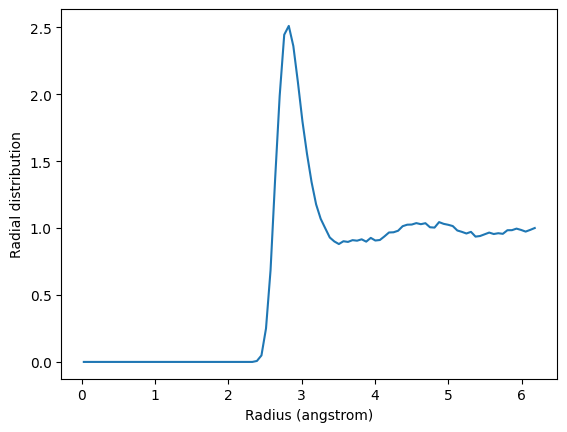

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Ordf.bins, Ordf.rdf)
plt.xlabel("Radius (angstrom)")
plt.ylabel("Radial distribution")

### You can compare the O-O rdf above with the one obtained from a longer AIMD trajectory with the SCAN functional. The two rdfs are rather close to each other.

https://www.pnas.org/doi/suppl/10.1073/pnas.2121641119/suppl_file/pnas.2121641119.sapp.pdf

Text(0, 0.5, 'Radial distribution')

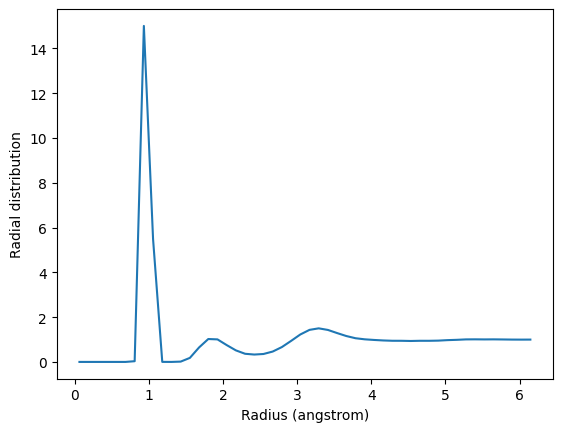

In [ ]:
plt.plot(OHrdf.bins, OHrdf.rdf)
plt.xlabel("Radius (angstrom)")
plt.ylabel("Radial distribution")

Text(0, 0.5, 'Radial distribution')

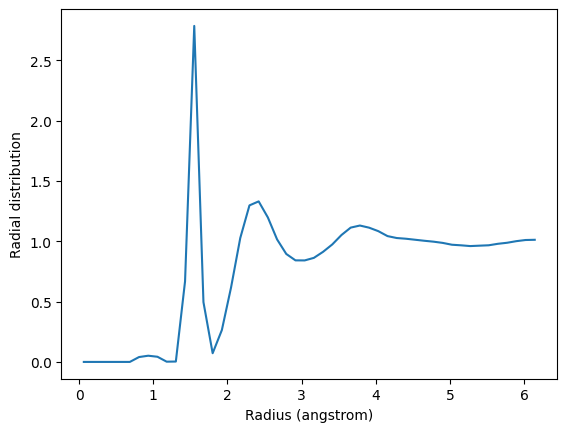

In [ ]:
plt.plot(HHrdf.bins, HHrdf.rdf)
plt.xlabel("Radius (angstrom)")
plt.ylabel("Radial distribution")

## Plot Total Energy and Temperature as a function of time after 5ps of equilibration to check the overall stability of the MD

<Axes: xlabel='Time[fs]'>

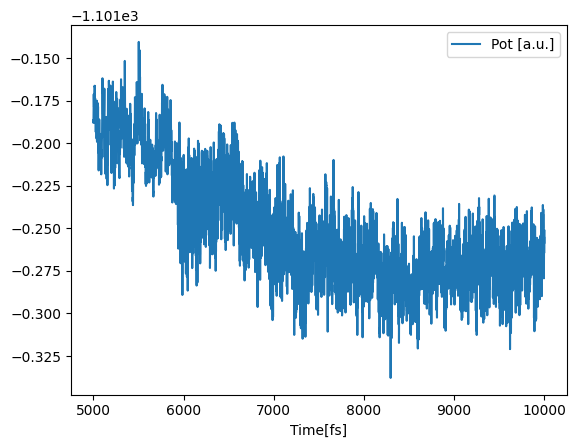

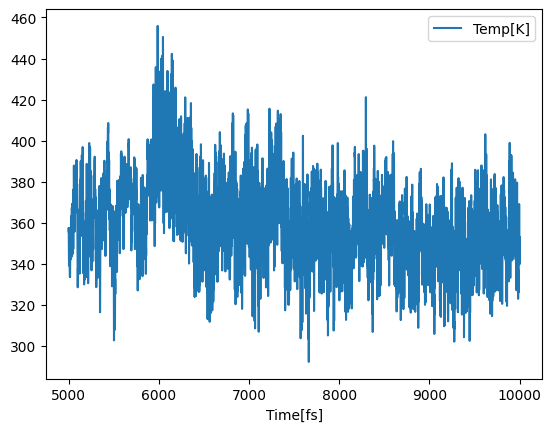

In [ ]:
import pandas as pd
ener_file = pd.read_csv("/content/cp2k_run/water-1.ener", delim_whitespace=True, header = 0)

ener_file = ener_file.drop(columns="#").rename(columns = {"Step" : "Time[fs]", "Nr.": "Kin.[a.u.]",
                                              "Time[fs]": "Temp[K]",
                                              "Kin.[a.u.]": "Pot [a.u.]","Temp[K]": "Cons Qty[a.u.]",
                                              "Pot.[a.u.]": "Used Time[s]"
                                              }).drop(columns=["Cons","Qty[a.u.]","UsedTime[s]"])
ener_file[10000:].plot(x="Time[fs]",y="Pot [a.u.]")
ener_file[10000:].plot(x="Time[fs]",y="Temp[K]")
